# Homework 2

This assignment is to help you get used to PyTorch (and to improve your googling skills).

If this is your first PyTorch experience, you may want to [start here](https://pytorch.org/tutorials/).

While learning PyTorch, you will have lots of questions, like

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use etc.

To find the answers, you are expected to google a lot and to refer to [documentation](https://pytorch.org/docs/stable/index.html). Quick documentation on functions and modules is available with `?` and `help()`, like so:

```python
help(torch.sqrt)
```

```python
# to close the help bar, press `Esc` or `q`
?torch.cat
```

In this assignment, <font color="red">**you are NOT ALLOWED to:**</font>
* use NumPy, SciPy or any other tensor library except PyTorch;
* emulate PyTorch tensors (that are used for large arrays of numbers) with lists or tuples;
* emulate any tensor functionality with other libraries/loops/indexing if it's directly native to PyTorch. Example:

```python
x = torch.rand(1_000_000)

# Wrong: slow and unreadable
for idx in range(x.numel()):
    x[idx] = math.sqrt(x[idx])

# Correct
x.sqrt_()
```

## Part 1 (40 points total)

**In this part only**, you are <font color="red">**NOT ALLOWED**</font> to use any PyTorch submodules, including
* `torch.nn`,
* `torch.nn.functional` (in general, try to always avoid using it),
* `torch.optim`,
* `torch.utils.data`,
* `torch.distributions`...

Instead, use only PyTorch core functions, such as `torch.avg_pool1d(x)`, `torch.conv2d` or `torch.no_grad()`. Where possible, use special operators syntax (e.g. `x @ y`, `x += 17`, `x[None]`) or tensor methods (e.g. `x.to(y)`, `x.relu()`, `x.copy_(y)`).

<br>

**FAQ** (click to expand)

<details>
<summary><i>Hey look what's wrong with <code>torch.nn.functional</code>? I've always used it! It's in all the tutorials!</i></summary>
<ul>
<li>A huge portion of its functions are in PyTorch core. For example, there are <code>torch.max_pool1d_with_indices</code>, <code>torch.pdist</code>, <code>torch.batch_norm</code> etc.
<li>Many parts of it, like <code>torch.nn.functional.tanh</code>, are explicitly deprecated.
<li>In general, given the tendency of migrating <code>torch.nn.functional.*</code> into <code>torch.*</code>, I have a strong impression that they will soon deprecate the whole submodule (but that's just my hypothesis).
<li><a href="https://discuss.pytorch.org/t/how-to-choose-between-torch-nn-functional-and-torch-nn-module/2800">It's a</a> frequent <a href="https://www.reddit.com/r/pytorch/comments/afy3rt/torchnnfunctional/">source</a> of <a href="https://discuss.pytorch.org/t/whats-the-difference-between-torch-nn-functional-and-torch-nn/681">confusion</a>, especially for newbies.
<li>It clutters the code. <code>x.softmax()</code> and <code>torch.softmax(x)</code> are better than <code>torch.nn.functional.softmax(x)</code> and <code>F.softmax(x)</code>.
</ul>

Though I have to admit you can't avoid it at all, e.g. there are unique <code>torch.nn.functional.triplet_margin_loss</code> and <code>torch.nn.functional.softmin</code>. But in this assignment, you can. 😉
</details>


In [1]:
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2021 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Imports

# 1. Libraries
import torch
import numpy as np               # results verification during grading

import matplotlib.pyplot as plt  # 2D plot in task 1
%matplotlib inline

# 2. Extra custom code for this assignment
from animation import Animation              # animations in task 2
# if animations don't work, try uncommenting this line:
from animation import AnimationMJPG as Animation
from notmnist import load_notmnist           # dataset for task 3

# 3. Your solution
%load_ext autoreload
%autoreload 1

%aimport part1_solution

### Task 1 (3 points)

$\rho(\theta)$ is defined in the polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a **64-bit floating point** regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these points.
3. Convert the result into Cartesian coordinates ([see here how](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [3]:
x, y = part1_solution.get_rho()

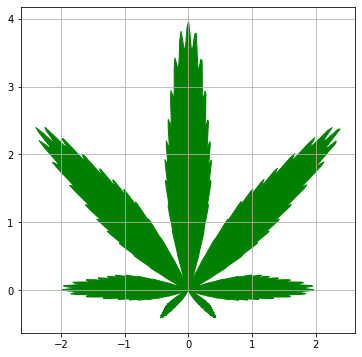

In [4]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=(6,6))
plt.fill(x, y, color='green')
plt.grid()

In [5]:
assert \
    np.allclose(x.sum(), -1.9854999999997989, atol=1e-4) and \
    np.allclose(y.mean(), 0.44955, atol=1e-4), \
    "Task 1: you've made an error somewhere"
print("Task 1: well done!")

Task 1: well done!


### Task 2 (7 points)

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

In case you skipped the above hyperlink, here is the algorithm:
* You have a 2D grid of cells, where each cell is "alive" or "dead" (has a value of `1` or `0` respectively).
* At each step in time, the so-called "generation update" happens:
  * any alive cell that has 2 or 3 alive neighbors survives, otherwise (0, 1 or 4+ neighbors) it dies;
  * any dead cell with exactly 3 alive neighbors becomes alive.

You are given a (slow) reference implementation of the generation update. Your task is to convert it to PyTorch (faster). Avoid datatype conversions, and, as always, remember to not use loops over tensor elements etc., just PyTorch operations.

In [6]:
def game_of_life_update_reference(alive_map):
    """
    Game of Life update function (in-place).
    
    alive_map:
        `numpy.ndarray`, ndim == 2, dtype == `numpy.int64`
        The game map containing 0s (dead) an 1s (alive).
    """
    # Count neighbours for each cell with convolution
    num_alive_neighbors = np.zeros_like(alive_map)
    h, w = alive_map.shape

    for row in range(h):
        for col in range(w):
            for row_d in range(-1, 2):
                for col_d in range(-1, 2):
                    if row_d == col_d == 0:
                        continue
                    if 0 <= row + row_d < h and 0 <= col + col_d < w:
                        num_alive_neighbors[row, col] += alive_map[row + row_d, col + col_d]
    
    # Apply game rules
    new_alive_map = np.empty_like(alive_map)
    for row in range(h):
        for col in range(w):
            born = num_alive_neighbors[row, col] == 3 and alive_map[row, col] == 0
            survived = num_alive_neighbors[row, col] in (2,3) and alive_map[row, col] == 1
            new_alive_map[row, col] = born or survived
    
    # Output the result
    np.copyto(alive_map, new_alive_map)

In [7]:

for _ in range(10):
    # Generate a random initial map
    alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100)).astype(np.int64)
    alive_map_torch = torch.from_numpy(alive_map_numpy).float().clone()

    game_of_life_update_reference(alive_map_numpy)
    part1_solution.game_of_life_update_torch(alive_map_torch)

    # Results must be identical
    assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
        "Your PyTorch implementation doesn't match `game_of_life_update_reference`."

print("Task 2: well done!")

Task 2: well done!


In [8]:
animation = Animation(monochrome=True)

# Initialize game field
np.random.seed(666)
alive_map = np.random.choice([0, 1], size=(100, 100)).astype(np.int64)
alive_map = torch.from_numpy(alive_map).float()

for _ in range(101):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    part1_solution.game_of_life_update_torch(alive_map)

animation.display()

In [9]:
animation = Animation(monochrome=True)

# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros((100, 100), dtype=np.int64)
alive_map[48:52, 50] = 1

alive_map = torch.from_numpy(alive_map).float()

for _ in range(150):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    part1_solution.game_of_life_update_torch(alive_map)

animation.display()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

### Task 3 (30 points)

This task is to teach you PyTorch's autograd (automatic differentiation) functionality. So, this time, don't code your own backprop manually like in the assignment №1.

You have to solve yet another character recognition problem: *notMNIST* dataset of 10 letters and ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% validation accuracy,
1. at least 2 linear layers,
1. no convolutions,
1. [categorical cross-entropy loss](https://gombru.github.io/2018/05/23/cross_entropy_loss/) (`x.log_softmax()` recommended for numerical stability),
1. training and evaluation should in total **take at most 15 seconds** (roughly),
1. no GPU.

Tips:

* This is a much simpler problem than that in homework 1. So don't use the structures from there (`Sequential`, `.forward()` etc.), they will be an overkill here. We suggest that your `NeuralNet.predict()` consists of 5-7 lines.
* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization parameters, weights initialization.

Happy googling!

In [10]:
# Download and initialize dataset
letters = 'ABCDEFGHIJ'
X_train, y_train, X_val, y_val = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_val.squeeze_();

Parsing... (it's OK if <10 images are broken)
Found broken image: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Found broken image: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


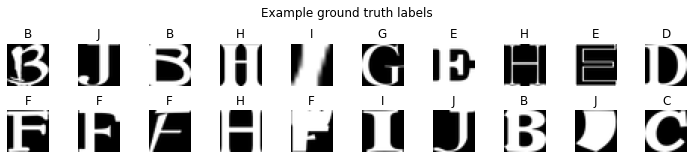

In [11]:
# Display a part of the dataset
fig, axarr = plt.subplots(2, 10, figsize=(10, 2))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

fig.suptitle("Example ground truth labels", y=1.08)
fig.tight_layout();

In [12]:
# Initialize the neural net
np.random.seed(666)
torch.manual_seed(666)

model = part1_solution.NeuralNet()

In [13]:
%%time
torch.set_num_threads(1)

# Train
part1_solution.train_on_notmnist(model, X_train, y_train, X_val, y_val)

100%|██████████| 200/200 [01:18<00:00,  2.54it/s]

CPU times: user 1min 16s, sys: 942 ms, total: 1min 17s
Wall time: 1min 18s


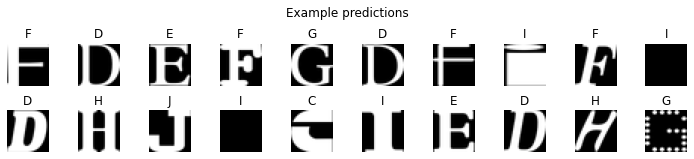

In [14]:
# Run it on some validation samples
example_batch = (torch.arange(20) + 1) * 31
_, example_batch_predictions = model.predict(X_val[example_batch]).max(1)

fig, axarr = plt.subplots(2, 10, figsize=(10, 2))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_val[example_batch[idx]], cmap='gray')
    ax.axis('off')
    ax.set_title(letters[example_batch_predictions[idx]])

fig.suptitle("Example predictions", y=1.08)
fig.tight_layout();

In [15]:
# Run it on all data, compute accuracies
train_accuracy = part1_solution.accuracy(model, X_train, y_train) * 100
val_accuracy = part1_solution.accuracy(model, X_val, y_val) * 100
print("Training accuracy: %.2f, validation accuracy: %.2f" % (train_accuracy, val_accuracy))

assert val_accuracy >= 82.0, "You have to do better"
print("Task 3: well done!")

Training accuracy: 94.49, validation accuracy: 90.39
Task 3: well done!
